<a href="https://colab.research.google.com/github/ATIK2110018/deep-learning/blob/main/satelite_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install patchify

In [ ]:
from patchify import patchify,unpatchify

In [ ]:
!pip install tensorflow -q

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,MaxPool2D,Dropout,Flatten,Dense
from tensorflow.keras import Input,Model

In [ ]:
# here batchnormalization is additionally used so we have to put activation after normalization separately
def conv_block(input,num_filter):
  x=Conv2D(num_filter,3,padding="same")(input)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)

  x=Conv2D(num_filter,3,padding="same")(x)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)
  return x

In [ ]:
def encoder_block(input,num_filter):
  x=conv_block(input,num_filter)
  p=MaxPool2D((2,2))(x)
  return x,p

In [ ]:
def decoder_block(input,skip_feature,num_filter):
  x=Conv2DTranspose(num_filter,2,strides=2,padding='same')(input) #here filter size =2*2 was used . and we are doubling the size so strides=2
  x=Concatenate()([x,skip_feature])
  x=conv_block(x,num_filter)
  return x

In [ ]:
#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(6, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass) then  #Conv2D(num_classes,1,padding='same',activation='relu')(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

# Now we will do a image segmentation using this model

In [ ]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import tifffile as tiff
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam

In [ ]:
path="/content/drive/MyDrive/Colab Notebooks/Deep Learning/datasets/DubaiDataset"

In [ ]:
image=[]
def read_img(path):
    for i in range(1,8):
        for j in range(1,9):
            img_path = f"{path}/Tile {i}/images/image_part_00{j}.jpg"
            img = cv2.imread(img_path)
            if img is not None:
                image.append(img)
            else:
                print(f"Warning: Could not read image at {img_path}")

In [ ]:
mask=[]
def read_msk(path):
    for i in range(1,8):
        for j in range(1,9):
            msk_path = f"{path}/Tile {i}/masks/image_part_00{j}.png"
            msk = cv2.imread(msk_path,cv2.COLOR_BGR2RGB)
            if msk is not None:
                mask.append(msk)
            else:
                print(f"Warning: Could not read image at {msk_path}")

In [ ]:
images=read_img(path)

In [ ]:
if image:
    print("Shape of each image in the list:")
    for i, img in enumerate(image):
        print(f"Image {i}: {img.shape}")
else:
    print("The 'image' list is empty.")

Shape of each image in the list:
Image 0: (644, 797, 3)
Image 1: (644, 797, 3)
Image 2: (644, 797, 3)
Image 3: (643, 797, 3)
Image 4: (643, 797, 3)
Image 5: (643, 797, 3)
Image 6: (644, 797, 3)
Image 7: (644, 797, 3)
Image 8: (544, 509, 3)
Image 9: (544, 510, 3)
Image 10: (544, 509, 3)
Image 11: (544, 509, 3)
Image 12: (544, 510, 3)
Image 13: (544, 509, 3)
Image 14: (544, 509, 3)
Image 15: (544, 510, 3)
Image 16: (658, 682, 3)
Image 17: (658, 682, 3)
Image 18: (658, 682, 3)
Image 19: (658, 682, 3)
Image 20: (658, 682, 3)
Image 21: (658, 682, 3)
Image 22: (658, 682, 3)
Image 23: (658, 682, 3)
Image 24: (846, 1099, 3)
Image 25: (846, 1099, 3)
Image 26: (846, 1099, 3)
Image 27: (846, 1099, 3)
Image 28: (846, 1099, 3)
Image 29: (846, 1099, 3)
Image 30: (846, 1099, 3)
Image 31: (846, 1099, 3)
Image 32: (1058, 1126, 3)
Image 33: (1058, 1126, 3)
Image 34: (1058, 1126, 3)
Image 35: (1058, 1126, 3)
Image 36: (1058, 1126, 3)
Image 37: (1058, 1126, 3)
Image 38: (1058, 1126, 3)
Image 39: (1058, 11

In [ ]:
masks=read_msk(path)

In [ ]:
if mask:
    print("Shape of each mask in the list:")
    for i, msk in enumerate(mask):
        print(f"Mask {i}: {msk.shape}")
else:
    print("The 'masks' list is empty.")

Shape of each mask in the list:
Mask 0: (644, 797, 3)
Mask 1: (644, 797, 3)
Mask 2: (644, 797, 3)
Mask 3: (643, 797, 3)
Mask 4: (643, 797, 3)
Mask 5: (643, 797, 3)
Mask 6: (644, 797, 3)
Mask 7: (644, 797, 3)
Mask 8: (544, 509, 3)
Mask 9: (544, 510, 3)
Mask 10: (544, 509, 3)
Mask 11: (544, 509, 3)
Mask 12: (544, 510, 3)
Mask 13: (544, 509, 3)
Mask 14: (544, 509, 3)
Mask 15: (544, 510, 3)
Mask 16: (658, 682, 3)
Mask 17: (658, 682, 3)
Mask 18: (658, 682, 3)
Mask 19: (658, 682, 3)
Mask 20: (658, 682, 3)
Mask 21: (658, 682, 3)
Mask 22: (658, 682, 3)
Mask 23: (658, 682, 3)
Mask 24: (846, 1099, 3)
Mask 25: (846, 1099, 3)
Mask 26: (846, 1099, 3)
Mask 27: (846, 1099, 3)
Mask 28: (846, 1099, 3)
Mask 29: (846, 1099, 3)
Mask 30: (846, 1099, 3)
Mask 31: (846, 1099, 3)
Mask 32: (1058, 1126, 3)
Mask 33: (1058, 1126, 3)
Mask 34: (1058, 1126, 3)
Mask 35: (1058, 1126, 3)
Mask 36: (1058, 1126, 3)
Mask 37: (1058, 1126, 3)
Mask 38: (1058, 1126, 3)
Mask 39: (1058, 1126, 3)
Mask 40: (838, 859, 3)
Mask 41: (8

In [ ]:
mask[0].shape

(644, 797, 3)

In [ ]:
resized_mask=[]
if mask:
    print("Shape of each mask in the list:")
    for i, msk in enumerate(mask):
        msk_res=cv2.resize(msk,((msk.shape[1]//256)*256,(msk.shape[0]//256)*256))
        print(f"resized mask {i}: {msk_res.shape}")
        resized_mask.append(msk_res)
else:
    print("The 'masks' list is empty.")

Shape of each mask in the list:
resized mask 0: (512, 768, 3)
resized mask 1: (512, 768, 3)
resized mask 2: (512, 768, 3)
resized mask 3: (512, 768, 3)
resized mask 4: (512, 768, 3)
resized mask 5: (512, 768, 3)
resized mask 6: (512, 768, 3)
resized mask 7: (512, 768, 3)
resized mask 8: (512, 256, 3)
resized mask 9: (512, 256, 3)
resized mask 10: (512, 256, 3)
resized mask 11: (512, 256, 3)
resized mask 12: (512, 256, 3)
resized mask 13: (512, 256, 3)
resized mask 14: (512, 256, 3)
resized mask 15: (512, 256, 3)
resized mask 16: (512, 512, 3)
resized mask 17: (512, 512, 3)
resized mask 18: (512, 512, 3)
resized mask 19: (512, 512, 3)
resized mask 20: (512, 512, 3)
resized mask 21: (512, 512, 3)
resized mask 22: (512, 512, 3)
resized mask 23: (512, 512, 3)
resized mask 24: (768, 1024, 3)
resized mask 25: (768, 1024, 3)
resized mask 26: (768, 1024, 3)
resized mask 27: (768, 1024, 3)
resized mask 28: (768, 1024, 3)
resized mask 29: (768, 1024, 3)
resized mask 30: (768, 1024, 3)
resized ma

In [ ]:
print(resized_mask[0])

[[[246  41 132]
  [246  41 132]
  [246  41 132]
  ...
  [246  41 132]
  [246  41 132]
  [246  41 132]]

 [[246  41 132]
  [246  41 132]
  [246  41 132]
  ...
  [246  41 132]
  [246  41 132]
  [246  41 132]]

 [[246  41 132]
  [246  41 132]
  [246  41 132]
  ...
  [246  41 132]
  [246  41 132]
  [246  41 132]]

 ...

 [[246  41 132]
  [246  41 132]
  [246  41 132]
  ...
  [246  41 132]
  [246  41 132]
  [246  41 132]]

 [[246  41 132]
  [246  41 132]
  [246  41 132]
  ...
  [246  41 132]
  [246  41 132]
  [246  41 132]]

 [[246  41 132]
  [246  41 132]
  [246  41 132]
  ...
  [246  41 132]
  [246  41 132]
  [246  41 132]]]


In [ ]:
resized_image=[]
if image:
    print("Shape of each mask in the list:")
    for i, img in enumerate(image):
        img_res=cv2.resize(img,((img.shape[1]//256)*256,(img.shape[0]//256)*256))
        print(f"resized image {i}: {img_res.shape}")
        resized_image.append(img_res)
else:
    print("The 'masks' list is empty.")

Shape of each mask in the list:
resized image 0: (512, 768, 3)
resized image 1: (512, 768, 3)
resized image 2: (512, 768, 3)
resized image 3: (512, 768, 3)
resized image 4: (512, 768, 3)
resized image 5: (512, 768, 3)
resized image 6: (512, 768, 3)
resized image 7: (512, 768, 3)
resized image 8: (512, 256, 3)
resized image 9: (512, 256, 3)
resized image 10: (512, 256, 3)
resized image 11: (512, 256, 3)
resized image 12: (512, 256, 3)
resized image 13: (512, 256, 3)
resized image 14: (512, 256, 3)
resized image 15: (512, 256, 3)
resized image 16: (512, 512, 3)
resized image 17: (512, 512, 3)
resized image 18: (512, 512, 3)
resized image 19: (512, 512, 3)
resized image 20: (512, 512, 3)
resized image 21: (512, 512, 3)
resized image 22: (512, 512, 3)
resized image 23: (512, 512, 3)
resized image 24: (768, 1024, 3)
resized image 25: (768, 1024, 3)
resized image 26: (768, 1024, 3)
resized image 27: (768, 1024, 3)
resized image 28: (768, 1024, 3)
resized image 29: (768, 1024, 3)
resized imag

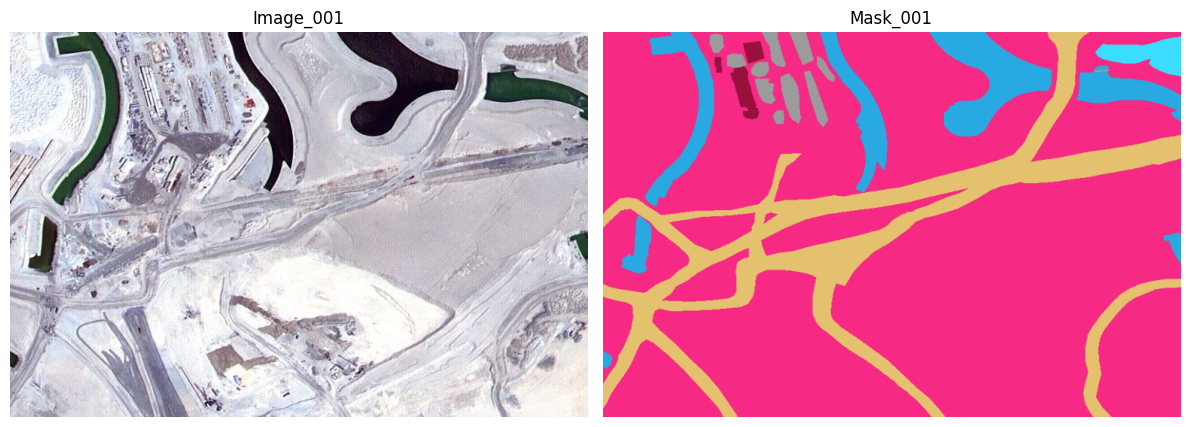

In [ ]:
fig,axes=plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(cv2.cvtColor(resized_image[0], cv2.COLOR_BGR2RGB))
axes[0].set_title("Image_001")
axes[0].axis('off')

axes[1].imshow(resized_mask[0], cmap='gray')
axes[1].set_title("Mask_001")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
resized_image[0].shape

(512, 768, 3)

In [ ]:
image_patches = []
mask_patches = []
patch_size = 256

for image, mask in zip(resized_image, resized_mask):
    image = np.array(image)
    mask = np.array(mask)

    img_patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)
    mask_patches_temp = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

    for row in range(img_patches.shape[0]):
        for col in range(img_patches.shape[1]):
            image_patches.append(img_patches[row, col, 0])
            mask_patches.append(mask_patches_temp[row, col, 0])

In [ ]:
image_patches[0].shape

(256, 256, 3)

In [ ]:
mask_patches[0].shape

(256, 256, 3)

In [ ]:
# convert labels from hexadecimal to RGB
# Calculating RGB from HEX: #3C1098
# 3C = 3*16 + 12 = 60
# 10 = 1*16 + 0 = 16
# 98 = 9*16 + 8 = 152

In [ ]:
#how python handles hex values
a=int('3C', 16)  #3C with base 16. Should return 60.
print(a)

60


In [ ]:
Land =[246, 41, 132]

Building =[152, 16, 60]

Road =[228, 193, 110]

Vegetation =[58, 221, 254]

Water =[41, 169, 226]

Unlabeled =[155, 155, 155]

array([[[246,  41, 132],
        [246,  41, 132],
        [246,  41, 132],
        ...,
        [246,  41, 132],
        [246,  41, 132],
        [246,  41, 132]],

       [[246,  41, 132],
        [246,  41, 132],
        [246,  41, 132],
        ...,
        [246,  41, 132],
        [246,  41, 132],
        [246,  41, 132]],

       [[246,  41, 132],
        [246,  41, 132],
        [246,  41, 132],
        ...,
        [246,  41, 132],
        [246,  41, 132],
        [246,  41, 132]],

       ...,

       [[246,  41, 132],
        [246,  41, 132],
        [246,  41, 132],
        ...,
        [246,  41, 132],
        [246,  41, 132],
        [246,  41, 132]],

       [[246,  41, 132],
        [246,  41, 132],
        [246,  41, 132],
        ...,
        [246,  41, 132],
        [246,  41, 132],
        [246,  41, 132]],

       [[246,  41, 132],
        [246,  41, 132],
        [246,  41, 132],
        ...,
        [246,  41, 132],
        [246,  41, 132],
        [246,  41, 132]]], dtype=uint8)
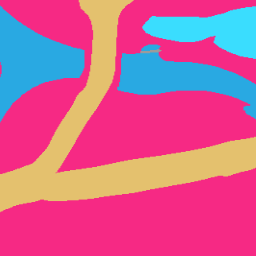

In [ ]:
mask_patches[2]

In [ ]:
Land

[246, 41, 132]

In [ ]:
mask_patches=np.array(mask_patches)

In [ ]:
# # Now replace RGB to integer values to be used as labels.
# #Find pixels with combination of RGB for the above defined arrays...
# #if matches then replace all values in that pixel with a specific integer
# def rgb_to_label(label):
#     label_seg = np.zeros(label.shape,dtype=np.uint8)
#     label_seg[np.all(label == Building,axis=-1)] = 0
#     label_seg[np.all(label == Land,axis=-1)] = 1
#     label_seg[np.all(label==Road,axis=-1)] = 2
#     label_seg[np.all(label==Vegetation,axis=-1)] = 3
#     label_seg[np.all(label==Water,axis=-1)] = 4
#     label_seg[np.all(label==Unlabeled,axis=-1)] = 5

#     label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    # return label_seg

In [ ]:
# labels=[]
# for i in range(mask_patches.shape[0]):
#     label= rgb_to_label(mask_patches[i])
#     labels.append(label)

# labels=np.array(labels)

In [ ]:
def rgb_to_label(label):
    label_seg = np.zeros((label.shape[0], label.shape[1]), dtype=np.uint8)

    label_seg[np.all(label == Building, axis=-1)] = 0
    label_seg[np.all(label == Land, axis=-1)] = 1
    label_seg[np.all(label == Road, axis=-1)] = 2
    label_seg[np.all(label == Vegetation, axis=-1)] = 3
    label_seg[np.all(label == Water, axis=-1)] = 4
    label_seg[np.all(label == Unlabeled, axis=-1)] = 5

    return label_seg

labels=[]
for i in range(mask_patches.shape[0]):
    label = rgb_to_label(mask_patches[i])
    labels.append(label)

labels = np.array(labels)

In [ ]:
labels.shape

(840, 256, 256)

In [ ]:
labels=np.expand_dims(labels, axis=3)

In [ ]:
labels.shape

(840, 256, 256, 1)

In [ ]:
np.unique(labels)  #unique values in labels

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [ ]:
images=np.array(image_patches)

In [ ]:
images.shape

(840, 256, 256, 3)

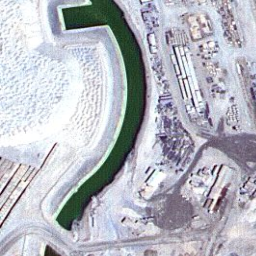

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(images[0])

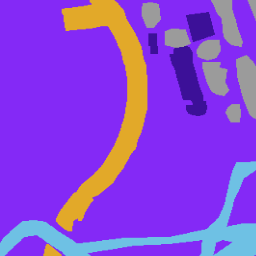

In [ ]:
cv2_imshow(mask_patches[0])

In [ ]:
mask_patches[0].shape

(256, 256, 3)

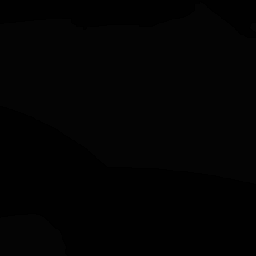

In [ ]:
cv2_imshow(labels[10])